<a href="https://colab.research.google.com/github/mathewhall100/fastai-course2019/blob/master/ISIC_skin_lesions_identification_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ISIC Skin Lesion Identification

Model to identifiy malignant from benign skin lesions. Data (5000 images -  approx 2000 of malignant melanoma and 3000 of benign nevi) was downloaded from the ISIC skin leasion archive  (https://www.isic-archive.com/#!/topWithHeader/onlyHeaderTop/gallery). Image processing was done on the command line using imageMagick and data saved as a 'train' folder containig all 5000 jpgs with corresponding csv files of filenames with labels (label '0' = benign nevi, '1' = malignant melanoma)

Currently the model is achieving at best of around 88% accuracy in differentiating malignant melanoma from benign lesions.

## Notebook setup

In [151]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
!pip install nbformat
!pip install nbconvert==5.4.1


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import libraries

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
from pandas import DataFrame

## Verify GPU status

In [155]:
print("GPU: ", torch.cuda.is_available())
print("Device = ", torch.device(torch.cuda.current_device()))
print("PyTorch version - ", torch.__version__)
print("Cuda version - ", torch.version.cuda)
print("cuDNN version - ", torch.backends.cudnn.version())
print("python PIL version - ", PIL.PILLOW_VERSION)

GPU:  True
Device =  cuda:0
PyTorch version -  1.1.0
Cuda version -  10.0.130
cuDNN version -  7501
python PIL version -  4.3.0


## Utilities

In [0]:
# Utility function to check for duplicates in a dataframe passed to it
def check_for_duplicates (df):
  df_set = set(df)
  if len(df_set) < len(df):
    return "duplicates found"
  else: return "no duplicates"

In [0]:
# Utility function to check that all labels have corresponding file and vice versa
def check_labels_have_files(labels, files):
  labels_set = set(labels)
  files_set = set(files)
  dif1 = labels_set - files_set
  dif2 = files_set - labels_set
  if len(dif1) > 0: 
    return "There are more labels than image files!"
  elif len(dif2) > 0:
    return "There are more image files than labels!"
  else: return "All labels have matching image files and vice versa"

In [0]:
# Utility function to plot a single image from 'train' folder
def plot_one(path, file):
  img = plt.imread(f'{path}/train/{file}')
  plt.imshow(img)

In [0]:
# Utility function to plot a series of images from 'train' folder
def plot_many(path, files):
  f, axarr = plt.subplots(3,3)
  for x in range(3):
    for y in range(3):
      z=(x*3)+y
      img = plt.imread(f'{path}/train/{files[z]}')
      plt.axis('off')
      axarr[x,y].imshow(img)

## Define parameters

In [0]:
bs_resnet34 = 64
bs_densenet = 16 
sz_sm = 224
sz_lg = 250

In [162]:
PATH = root_dir + "Colab Notebooks/data/ISIC/"
os.listdir(PATH)


['train',
 'labels_mm(old).csv',
 'labels_bn.csv',
 '.ipynb_checkpoints',
 'labels_mm.csv']

## Get data

*Note label '1' = maligmelanoma, label '0' = benign nevi

In [163]:
# Get image files from 'train folder'
train_files = os.listdir(f'{PATH}/train');
train_files[:5]

['ISIC_0033331.jpg',
 'ISIC_0033332.jpg',
 'ISIC_0033334.jpg',
 'ISIC_0033335.jpg',
 'ISIC_0033338.jpg']

In [164]:
# Get filenames of maligmelanoma images and load into dataframe
df_mm = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/ISIC/labels_mm.csv')
print("Images maligmelanoma: ", len(df_mm))
print(df_mm.head())

Images maligmelanoma:  2088
                  0  label
0  ISIC_0011112.jpg      1
1  ISIC_0031795.jpg      1
2  ISIC_0014189.jpg      1
3  ISIC_0026622.jpg      1
4  ISIC_0010329.jpg      1


In [165]:
# Get filenames of benign nevi images and load into dataframe
df_bn = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/ISIC/labels_bn.csv')
print("Images benign nevi: ", len(df_bn))
print(df_bn.head())

Images benign nevi:  3000
                  0  label
0  ISIC_0032832.jpg      0
1  ISIC_0026974.jpg      0
2  ISIC_0032785.jpg      0
3  ISIC_0032342.jpg      0
4  ISIC_0031635.jpg      0


In [166]:
# Combine the two label files into one for passing into Databunch
df_labels = pd.concat([df_mm, df_bn], ignore_index=True)
print("Images total: ", len(df))
print(df.head())
print(df.tail())

Images total:  5088
                  0  label
0  ISIC_0011112.jpg      1
1  ISIC_0031795.jpg      1
2  ISIC_0014189.jpg      1
3  ISIC_0026622.jpg      1
4  ISIC_0010329.jpg      1
                     0  label
5083  ISIC_0027237.jpg      0
5084  ISIC_0031809.jpg      0
5085  ISIC_0033474.jpg      0
5086  ISIC_0028000.jpg      0
5087  ISIC_0010719.jpg      0


## Examine data

In [167]:
# Get list of labels from dataframe column 0
label_files = df_labels["0"]
label_files[:5]

0    ISIC_0011112.jpg
1    ISIC_0031795.jpg
2    ISIC_0014189.jpg
3    ISIC_0026622.jpg
4    ISIC_0010329.jpg
Name: 0, dtype: object

In [182]:
print("labels: ", len(label_files), check_for_duplicates(label_files))
print("images: ", len(train_files), check_for_duplicates(train_files))

labels:  5088 no duplicates
images:  5088 no duplicates


In [189]:
check_labels_have_files(label_files, train_files)

'All labels have matching image fikes and vice versa'

maligmelanoma


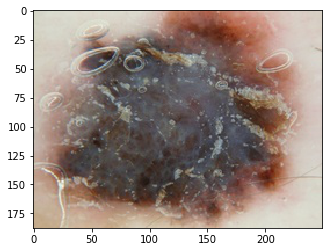

In [169]:
labels_mm = df_mm["0"]
print('maligmelanoma')
plot_one(PATH, labels_mm[0])
              

maligmelanomas


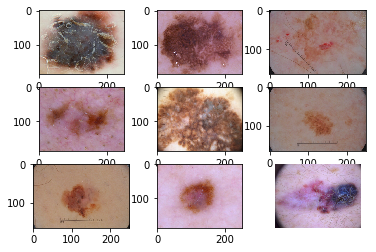

In [170]:
print("maligmelanomas")
plot_many(PATH, labels_mm[:9])

benign nevi


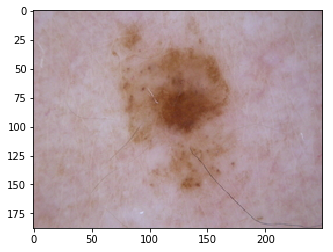

In [171]:
labels_bn = df_bn["0"]
print('benign nevi')
plot_one(PATH, labels_bn[0])

benign nevi


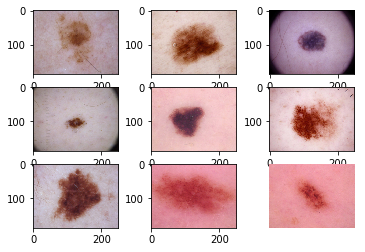

In [172]:
print("benign nevi")
plot_many(PATH, labels_bn[:9])

## Create imagedataBunch object (densenet161)

In [0]:
data_path = PATH + "train"

In [0]:
trfm = get_transforms()
train_img = (ImageList.from_df(df_labels, data_path)
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(trfm, size=sz_sm)
        .databunch(path='.', bs=bs_densenet, device=torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

In [175]:
train_img


ImageDataBunch;

Train: LabelList (4071 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /content/gdrive/My Drive/Colab Notebooks/data/ISIC/train;

Valid: LabelList (1017 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,0,0
Path: /content/gdrive/My Drive/Colab Notebooks/data/ISIC/train;

Test: None

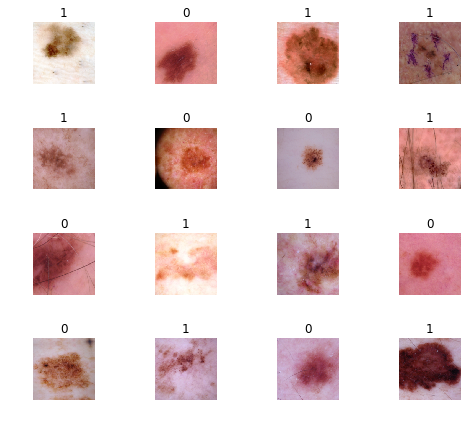

In [176]:
train_img.show_batch(rows=4, figsize=(7,6))

In [177]:
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy])
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.540868,0.409497,0.194690,0.805310,01:26
1,0.457819,0.357647,0.166175,0.833825,01:25
2,0.408225,0.337364,0.146509,0.853491,01:24
3,0.342348,0.342016,0.150442,0.849558,01:24
4,0.303489,0.321703,0.148476,0.851524,01:24


## Interpret results

In [0]:
learn.load('stage1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

'0' = benign nevi, '1' = malignant melanoma


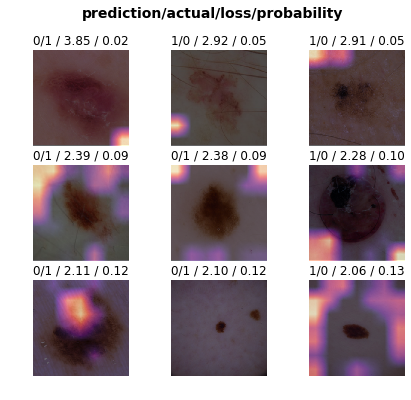

In [223]:
print("'0' = benign nevi, '1' = malignant melanoma")
interp.plot_top_losses(9, figsize=(7,6))

'0' = benign nevi, '1' = malignant melanoma


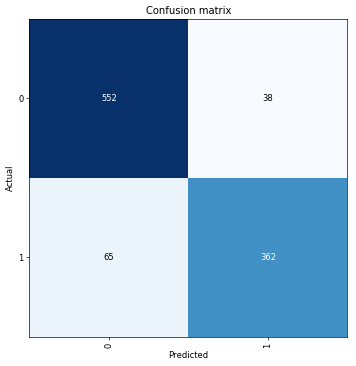

In [224]:
print("'0' = benign nevi, '1' = malignant melanoma")
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## Save Model

In [0]:
learn.save('stage1')

## Learning rate finder 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


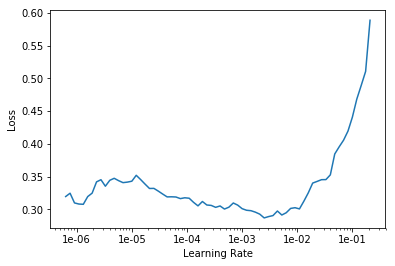

In [191]:
learn.lr_find()
learn.recorder.plot()

## Unfreeze

In [192]:
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy])
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('stage2')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.593798,0.453679,0.193707,0.806293,01:54
1,0.437170,0.369791,0.183874,0.816126,01:52
2,0.376476,0.335965,0.147493,0.852507,01:52
3,0.266864,0.282991,0.121927,0.878073,01:52
4,0.199818,0.280930,0.119961,0.880039,01:51


## Data augmentation

In [0]:
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

In [0]:
train_img = (ImageList.from_df(df, data_path)
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(trfm, size=sz_sm)
        .databunch(path='.', bs=bs_densenet, device=torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

In [195]:
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy])
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('stage3')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.583963,0.449225,0.199607,0.800393,01:52
1,0.442761,0.356533,0.168142,0.831858,01:52
2,0.360404,0.328336,0.172075,0.827925,01:52
3,0.321801,0.292726,0.139626,0.860374,01:52
4,0.281032,0.281792,0.125860,0.874140,01:52


## L2 regularization

In [196]:
learn = cnn_learner(train_img, models.densenet161, wd=0.1, metrics=[error_rate, accuracy])
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('stage4')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.594519,0.491733,0.213373,0.786627,01:52
1,0.507238,0.387944,0.174041,0.825959,01:51
2,0.402352,0.315167,0.149459,0.850541,01:52
3,0.342963,0.305891,0.144543,0.855457,01:51
4,0.298101,0.284978,0.128810,0.871190,01:51


In [197]:
learn = cnn_learner(train_img, models.densenet161, wd=1, metrics=[error_rate, accuracy])
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('stage5')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.557041,0.661167,0.272370,0.727630,01:51
1,0.428895,0.354671,0.162242,0.837758,01:51
2,0.378162,0.338661,0.157325,0.842675,01:51
3,0.316410,0.288782,0.137660,0.862340,01:51
4,0.285055,0.271702,0.122911,0.877090,01:51


In [207]:
learn = cnn_learner(train_img, models.densenet161, wd=1, metrics=[error_rate, accuracy])
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))
learn.save('stage6')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.609968,0.424202,0.206490,0.793510,01:52
1,0.466104,0.421161,0.193707,0.806293,01:51
2,0.419696,0.339164,0.161259,0.838741,01:51
3,0.374571,0.342613,0.157325,0.842675,01:51
4,0.342558,0.346462,0.170108,0.829892,01:51
5,0.322012,0.311465,0.138643,0.861357,01:51
6,0.300019,0.268670,0.117011,0.882989,01:51
7,0.241065,0.279259,0.129794,0.870206,01:51
8,0.206193,0.275623,0.128810,0.871190,01:51
9,0.195777,0.266876,0.117011,0.882989,01:51


## Interpret results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

'0' = benign nevi, '1' = malignant melanoma


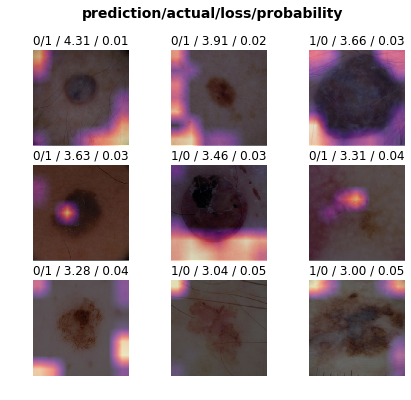

In [219]:
print("'0' = benign nevi, '1' = malignant melanoma")
interp.plot_top_losses(9, figsize=(7,6))

'0' = benign nevi, '1' = malignant melanoma


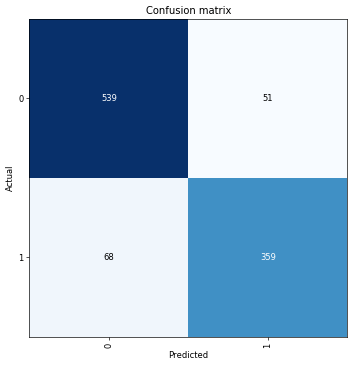

In [220]:
print("'0' = benign nevi, '1' = malignant melanoma")
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)